# Integrating snATAC-seq ortholog peak matrix
## human, macaque, and mouse caudate/caudoputamen

Notes on ortholog peaks notes: 
- reproduced peaks called in human, macaque, and mouse independently
- peaks pairwise mapped to orthologs via HALPER
    - keep only peaks mappable to all species
- ortholog peak set is the union of mappable orthologs from all species
    - not all ortholog peaks were reproducible peaks mapped in every dataset
    - unioning done in hg38 coordinates
    - this new peak set mapped back to mouse and macaque

- count matrix comes from union of mappable orthologs detected in any data set
    - the peaks in human, mouse, macaque used to get feature matrix in each species
    - feature matrix linked by peak name from hg38 coordinates
    - implies mappable ortholog changing chromatin accessibility between species

Notes on integration:
- perform integration with about same number of cells in each group
    - here selected representative human and macaque subject
    - also using a guide tree in iterative merging
- predefine the features during anchor finding step

In [1]:
PROJDIR=file.path('../../../data/raw_data/cross_species_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6.5)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))
suppressMessages(library(GenomicRanges))

source('../hal_scripts/narrowPeakFunctions.R')
parallel::detectCores()

[1] 40

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("sequential")
options(future.globals.maxSize = 180 * 1024^3)


Attaching package: 'future'


The following object is masked from 'package:GenomicRanges':

    values


The following object is masked from 'package:IRanges':

    values


The following object is masked from 'package:S4Vectors':

    values




# 1) visualize unintegrated species clusters

In [3]:
## load the ortholog peak seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'multispeciesMergedSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat

An object of class Seurat 
103883 features across 54473 samples within 1 assay 
Active assay: peaks (103883 features, 103883 variable features)
 2 dimensional reductions calculated: lsi, umap

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


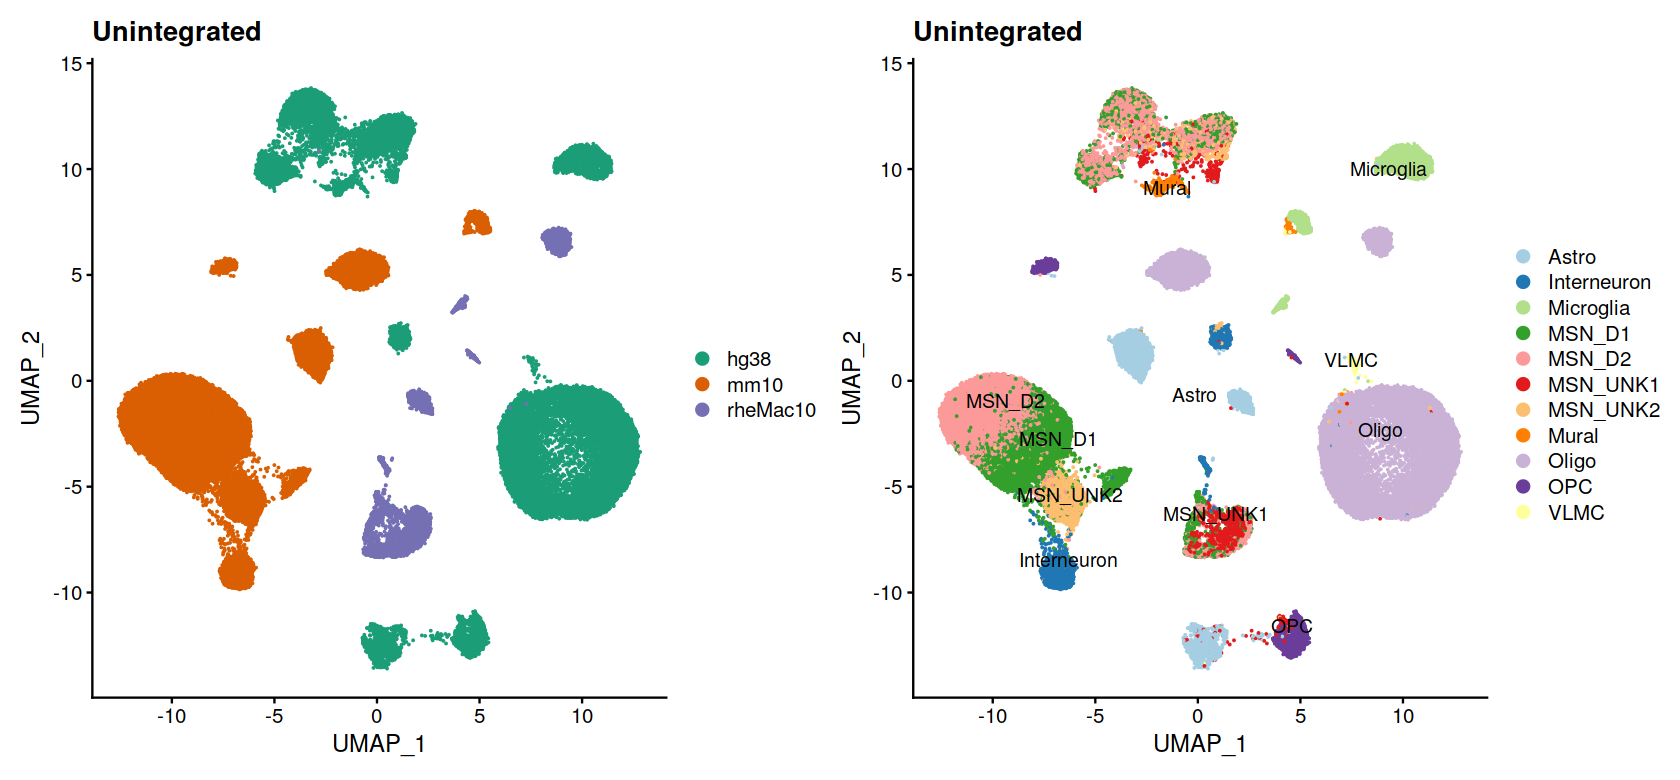

In [4]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Species', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with Seurat Intergration

In [5]:
# ## load the linked peaks seurat object
# linkedRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologMatrixSeurat.rds')
# linkedPeaksObj_seurat = readRDS(file = linkedRDS_fn)

# linkedPeaksObj_seurat

In [6]:
# # use the intersection of linked peaks and ortholog peaks for anchor finding
# oo = findOverlaps(query = StringToGRanges(rownames(obj_seurat)), 
#                   subject = StringToGRanges(rownames(linkedPeaksObj_seurat)))
# features = rownames(obj_seurat)[unique(queryHits(oo))]
# length(features)
# rm(linkedPeaksObj_seurat); gc();

In [7]:
## split seurat object up by species
obj_seurat.list = SplitObject(obj_seurat, split.by = 'Sample')
obj_seurat.list = lapply(obj_seurat.list, function(x){
  x <- RunTFIDF(x, verbose = FALSE)
  x <- FindTopFeatures(x, min.cutoff = 'q5')
})

# features <- SelectIntegrationFeatures(object.list = obj_seurat.list, nfeatures = 10000)
features <- rownames(obj_seurat)

## compute SVD on all peaks
obj_seurat.list <- lapply(X = obj_seurat.list, FUN = function(x) {
    x <- RunSVD(x, features = features, verbose = FALSE)
})

names(obj_seurat.list)

[1] "09_1589.CAUD"         "14_1018.CAUD"         "06_0615.CAUD"        
[4] "CAUD_WS1H_STA682A131" "CEMBA180813_5E"       "CEMBA171219_4D"      
[7] "CEMBA171214_4D"       "CEMBA180820_5E"

In [8]:
# find integration anchors between species, using all features

## save anchor
anchorRDS_fn = file.path(PROJDIR,'rdas','multispeciesSeuratCCAanchors.rds')

# if(!file.exists(anchorRDS_fn)){
if(TRUE){    
    anchors <- FindIntegrationAnchors(
        object.list = obj_seurat.list, reduction = 'cca', anchor.features = features,
        reference = c(1), # using 09_1589.CAUD 14_1018.CAUD as reference
        assay = rep('peaks', length(obj_seurat.list)))

    saveRDS(anchors, file = anchorRDS_fn)
} else {
    anchors = readRDS(file = anchorRDS_fn)
}
gc()

Scaling features for provided objects

Finding anchors between all query and reference datasets

Running CCA

Merging objects

Warning message in CreateChromatinAssay(data = merged.data, min.cells = 0, min.features = 0, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Finding neighborhoods

Finding anchors

	Found 20484 anchors

Filtering anchors

	Retained 555 anchors

Running CCA

Merging objects

Warning message in CreateChromatinAssay(data = merged.data, min.cells = 0, min.features = 0, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Finding neighborhoods

Finding anchors

	Found 23827 anchors

Filtering anchors

	Retained 577 anchors

Running CCA

Merging objects

Warning message in CreateChromatinAssay(data = merged.data, min.cells = 0, min.features = 0, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Finding neighborhoods

Finding anchors

	Found 21131 anchors

Filtering anchors

	Retained 737 anchors

Running CCA

Merging 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11192294,597.8,17062390,911.3,17062390,911.3
Vcells,6291630480,48001.4,16741963769,127731.1,16741961342,127731.1


In [9]:
# # define guide sample tree for pairwise merging
# sample.tree = matrix(c(-1, -2, # merge together  09_1589.CAUD   +  14_1018.CAUD 
#                         1, -3, # all human node
#                         1, -4, # all primate node (+ macaque sample)
#                        -5, -8, # CEMBA171214_4D CEMBA171219_4D 
#                        -6, -7, # CEMBA180813_5E CEMBA180820_5E
#                         1,  4, # add 4D mouse
#                         1,  5),# add 5E mouse
#                      ncol = 2, byrow = TRUE)

In [ ]:
# integrate data and create a new merged object
integrated <- IntegrateData(anchors, dims = 2:30, preserve.order = TRUE)

# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- RunSVD( object = integrated, n = 30)
integrated <- RunUMAP( object = integrated, dims = 2:30)

In [ ]:
## save the seurat object
integratedRDS_fn = file.path(PROJDIR, 'rdas', 'multispeciesSeuratCCA.rds')
system(paste('mkdir -p', dirname(integratedRDS_fn)))
saveRDS(integrated, file = integratedRDS_fn)

# 3) compare integrated snATAC-seq cell types

In [ ]:
p_integrated_species = 
    DimPlot(object = objHarmony, label = FALSE, group.by = 'Species', cols = 'Dark2') +
    ggplot2::ggtitle("Seurat integration")

p_integrated_clusters2 = 
    DimPlot(object = objHarmony, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle("Seurat integration")

p_integrated_species + p_integrated_clusters2